In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
import requests

api_key = ' NTOEPEBBL8O0LOEC'
symbol = 'IBM'  # Replace with the desired stock symbol

# API endpoint for weekly stock data
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol={symbol}&apikey={api_key}'

# Send the request to Alpha Vantage API
response = requests.get(url)
if response.status_code == 200:
    data = response.json()


In [4]:
time_series = data['Weekly Time Series']
    
    # Convert the time series data to a DataFrame
df = pd.DataFrame.from_dict(time_series, orient='index')
    
    # Convert index to datetime
df.index = pd.to_datetime(df.index)
    
    # Rename the columns
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Convert the data types
df = df.astype(float)
    
    # Display the first few rows of the DataFrame
print(df.head())
print(df.describe())

              Open      High       Low   Close      Volume
2024-08-15  191.25  194.2500  189.0001  193.95   8836382.0
2024-08-09  184.55  192.8800  181.8100  191.45  18895865.0
2024-08-02  193.18  194.5499  185.7000  189.12  20594367.0
2024-07-26  183.40  196.2600  182.8600  191.75  25458498.0
2024-07-19  183.38  189.4700  181.9500  183.25  17829469.0
              Open         High          Low        Close        Volume
count  1293.000000  1293.000000  1293.000000  1293.000000  1.293000e+03
mean    130.977875   133.942716   128.193756   131.110405  2.848852e+07
std      35.783606    36.002339    35.526297    35.809185  1.312791e+07
min      56.600000    62.000000    54.010000    56.600000  7.770697e+06
25%     100.440000   104.750000    97.930000   101.270000  1.882601e+07
50%     128.430000   131.230000   126.000000   128.480000  2.530990e+07
75%     155.050000   158.710000   152.350000   155.120000  3.481160e+07
max     212.900000   215.900000   210.110000   214.920000  1.108978e+0

In [5]:
df['Moving_Avg'] = df['Close'].rolling(window=3).mean()
df = df.dropna() 

In [6]:
# Scale the features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

print(df_scaled.head())


                Open      High       Low     Close    Volume  Moving_Avg
2024-08-02  0.873832  0.861273  0.843626  0.837039  0.124348    0.856819
2024-07-26  0.811260  0.872385  0.825432  0.853651  0.171515    0.852031
2024-07-19  0.811132  0.828265  0.819603  0.799962  0.097538    0.834182
2024-07-12  0.766539  0.793762  0.771557  0.797309  0.080488    0.820491
2024-07-05  0.747601  0.753606  0.764702  0.754295  0.021028    0.786252


In [7]:
def create_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        Y.append(data[i + time_step, 3])  # 3 is the index for 'Close'
    return np.array(X), np.array(Y)

# Set the time step (number of previous weeks to look back)
time_step = 3

# Create sequences
X, Y = create_sequences(df_scaled.values, time_step)

print(X.shape, Y.shape)  # Check the shape of the created sequences


(1288, 3, 6) (1288,)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)


(1030, 3, 6) (258, 3, 6)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input


In [10]:
model = Sequential()

# Add Input layer
model.add(Input(shape=(time_step, X_train.shape[2])))

# Add LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1675 - val_loss: 0.0091
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

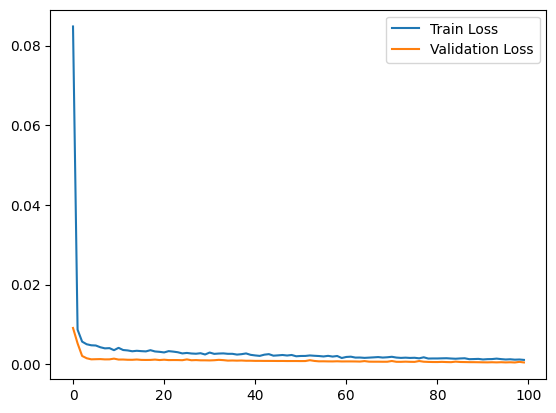

In [11]:
# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [12]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]

Y_train_inv = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]
Y_test_inv = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [13]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Training RMSE: 2.8827828720814375
Test RMSE: 3.3193114555142813


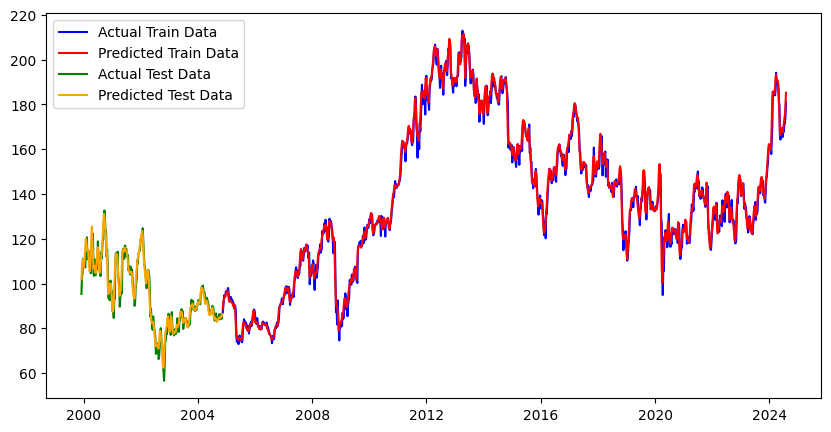

In [14]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(df.index[:len(train_predict)], Y_train_inv, color='blue', label='Actual Train Data')
plt.plot(df.index[:len(train_predict)], train_predict, color='red', label='Predicted Train Data')
plt.plot(df.index[len(train_predict):len(train_predict)+len(test_predict)], Y_test_inv, color='green', label='Actual Test Data')
plt.plot(df.index[len(train_predict):len(train_predict)+len(test_predict)], test_predict, color='orange', label='Predicted Test Data')
plt.legend()
plt.show()


In [15]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)